In [60]:
ls

2024-032-00.npy
GLM-L0-Background_G16_20240991337152_dqp.nc
GLM-L0-Background_G16_20240992337237_dqp.nc
GLM-L0-Background_G16_20240992342238_dqp.nc
GLM-L0-Background_G16_20241011717598_dqp.nc
GLM-L0-Background_G16_20241011722599_dqp.nc
GLM-L0-Background_G16_20241151547491_dqp.nc
GLM-L0-Background_G16_20241161433087_dqp.nc
OR_GLM-L2-GLMF-M3_G16_s20240730000000_e20240730002300_c20240741003550.nc
OR_GLM-L2-GLMF-M3_G16_s20240730000000_e20240730002300_c20240742203200.nc
OR_GLM-L2-GLMF-M3_G16_s20240730000000_e20240730002300_c20240791349340.nc
OR_GLM-L2-GLMF-M3_G16_s20240730000000_e20240730002300_c20240791353510.nc
OR_GLM-L2-GLMF-M3_G16_s20240730000000_e20240730002300_c20240791546020.nc
OR_GLM-L2-GLMF-M3_G16_s20240730000000_e20240730002300_c20240791546510.nc
OR_GLM-L2-GLMF-M3_G16_s20241011717590_e20241011720290_c20241011326170.nc
OR_GLM-L2-GLMF-M3_G16_s20241011717590_e20241011720290_c20241011347110.nc
OR_GLM-L2-GLMF-M3_G16_s20241011717590_e20241011720290_c20241011359280.nc
OR_GLM-L2-GLMF-M3_G

In [1]:
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
from dqf import dqf_from_nav_background

In [3]:
# ds_with_lonlat = xr.open_dataset('/Users/ebruning/Downloads/glm_nav_cal_bg_test.nc').load()

In [4]:
# ds_with_lonlat

In [5]:
# plt.figure()
# ds_with_lonlat.lons.plot()
# plt.figure()
# ds_with_lonlat.lats.plot()

In [6]:
import xarray as xr
# ds_in = xr.open_dataset('/Users/ebruning/Downloads/glm_nav_cal_bg_test.nc').load()
ds_in = xr.open_dataset('GLM-L0-Background_G16_20241161433087_dqp.nc').load()

In [7]:
ds_in

<xarray.Dataset>
Dimensions:  (y: 1372, x: 1300)
Dimensions without coordinates: y, x
Data variables:
    bg_img   (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    bg_dn    (y, x) int16 3134 3285 3275 3279 3281 ... 3354 3348 3350 3363 3082
    lats     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lons     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    Date Created:                    2024-04-25
    Date Valid:                      2024-04-25T143308
    Navigation Parameter Retrieval:  2024-032-00
    Version:                         alpha2a

In [8]:
ds_in.attrs.keys()

dict_keys(['Date Created', 'Date Valid', 'Navigation Parameter Retrieval', 'Version'])

In [9]:
datetime.strptime(ds_in.attrs['Date Valid'], '%Y-%m-%dT%H%M%S')

datetime.datetime(2024, 4, 25, 14, 33, 8)

In [10]:
print(ds_in.bg_img.min(), ds_in.bg_img.max())
print(ds_in.lons.min(), ds_in.lons.max())
print(ds_in.lats.min(), ds_in.lats.max())

<xarray.DataArray 'bg_img' ()>
array(6.169951e-16, dtype=float32) <xarray.DataArray 'bg_img' ()>
array(1.2035281e-13, dtype=float32)
<xarray.DataArray 'lons' ()>
array(-154.94395707) <xarray.DataArray 'lons' ()>
array(4.66749649)
<xarray.DataArray 'lats' ()>
array(-61.12613818) <xarray.DataArray 'lats' ()>
array(61.1829582)


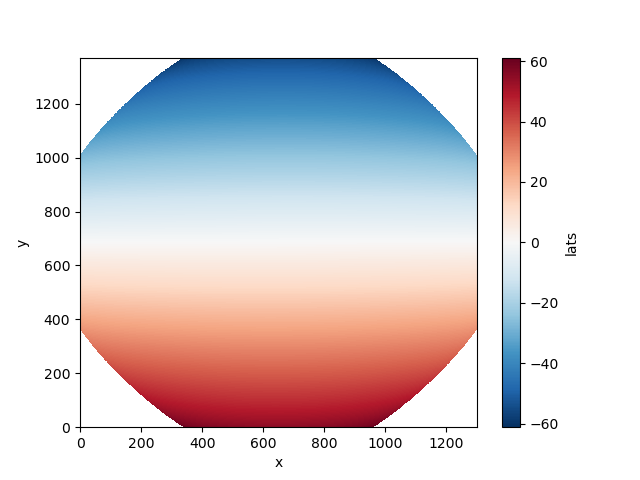

In [11]:
plt.figure()
lons = ds_in.lats.values
# lons.shape = 
ds_in.lats.plot()

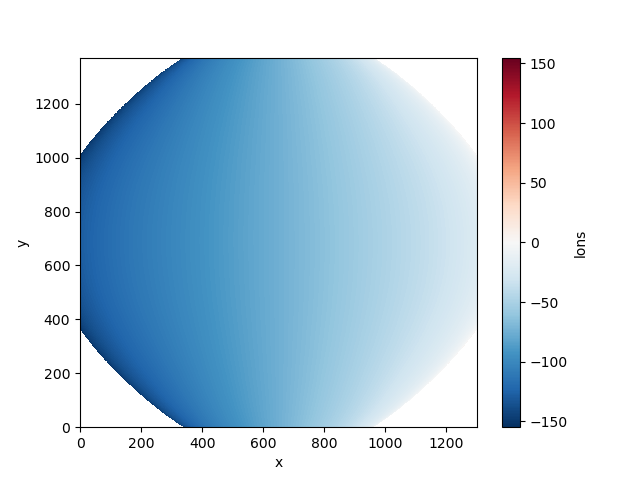

In [12]:
plt.figure()
lons = ds_in.lons.values
# lons.shape = 
ds_in.lons.plot()

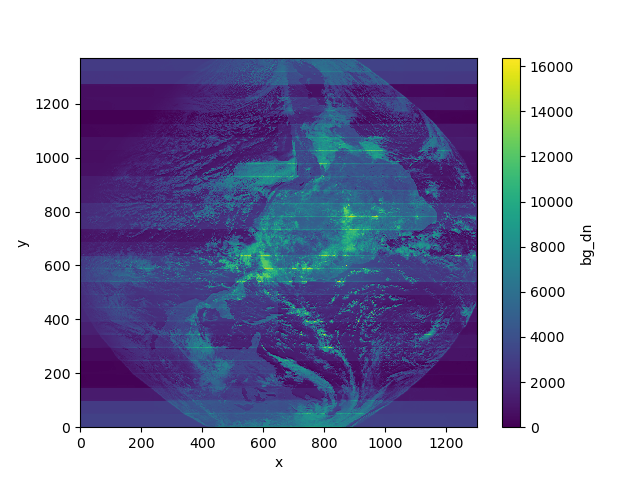

In [13]:
from matplotlib.colors import LogNorm
# energy_norm = LogNorm(vmin=5e-16, vmax=1e-13)
plt.figure()
ds_in.bg_dn.plot()#norm=energy_norm)

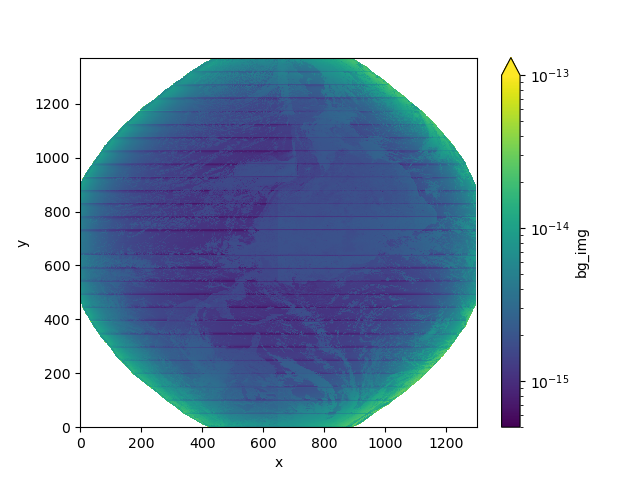

In [14]:
from matplotlib.colors import LogNorm
energy_norm = LogNorm(vmin=5e-16, vmax=1e-13)
plt.figure()
ds_in.bg_img.plot(norm=energy_norm)

In [15]:
# # All this will get replaced with output from Bitzer's code. 
# # Note shapes of arrays should match below.
import joblib
lat_joblib, lon_joblib, back_in = joblib.load('/Users/ebruning/Downloads/nav_bkgnd.joblib')
# Handle subsetting
# back = back_in[:1299, :1370]
lat_joblib.shape = (1299, 1370)
lon_joblib.shape = (1299, 1370)
# lat = lat_joblib
# lon = lon_joblib

# dn_max = 13000
# thresh_fJ =  8 - 8*back.astype(float)/float(dn_max)
# start = datetime(2024,3,13,0,0,0)
# end = datetime(2024,3,13,0,2,30)

In [16]:
# ds_in.attrs['Navigation Parameter Retrieval']

In [17]:
# For now pretend the background image above is from the joblib file, since those are the only good positions we have
# back_in.shape == (1300, 1372) from joblib, transposed from what we have here.
# So need to transpose lat and lon, and also subset back_in to match those shapes
# lat = lat_joblib.T
# lon = lon_joblib.T
# back = ds_in.bg_dn.values[:1370, :1299]
# thresh_fJ = 1.0e15*ds_in.bg_img.values[:1370, :1299]

back = ds_in.bg_dn.values 
lat = ds_in.lats.values
lon = ds_in.lons.values
thresh_fJ = 1.0e15*ds_in.bg_img.values
start = datetime.strptime(ds_in.attrs['Date Valid'], '%Y-%m-%dT%H%M%S')
end = start + timedelta(minutes=2, seconds=30)
cache_key = ds_in.attrs['Navigation Parameter Retrieval']

In [18]:
back.max()

16383

In [19]:
print(back.shape)
print(thresh_fJ.shape)
print(lon.shape)
print(lat.shape)

(1372, 1300)
(1372, 1300)
(1372, 1300)
(1372, 1300)


In [20]:
# Pack both products together in one byte?
combine = False

In [21]:
cache_key

'2024-032-00'

In [22]:
# TODO in dqf.py:
# Update dqf_from_nav_background to use the correct min and mix for back_cal,
#    which is as easy as changing the kwargs passed to scale_shift_back

cache_key = '2024-032-00-rev'
outfile = dqf_from_nav_background(start, end, lat, lon, back, back, thresh_fJ, cache_key=cache_key, combine_products=combine)

# Plot what we just created

In [23]:
from dqf import fde_colors, flag_colors, back_colors, dqp_mask, dqp_labels

dqp_colors = fde_colors + flag_colors
back_cmap = colors.ListedColormap(back_colors)
dqp_cmap = colors.ListedColormap(dqp_colors)

In [24]:
print(outfile)

./OR_GLM-L2-GLMF-M3_G16_s20241161433080_e20241161435380_c20241161445320.nc


In [26]:
# File we created above
ds = xr.open_dataset(outfile)

# Other test files
# See driver script in /data/GLM-back/testout/
# ds = xr.open_dataset("/data/GLM-back/testout/output/OR_GLM-L2-GLMF-M3_G16_s20241011717590_e20241011720290_c20241011516580.nc")
# ds = xr.open_dataset("/data/GLM-back/testout/output/OR_GLM-L2-GLMF-M3_G16_s20241011722590_e20241011725290_c20241011516590.nc")
# ds = xr.open_dataset("/data/GLM-back/testout/output/OR_GLM-L2-GLMF-M3_G16_s20241012038020_e20241012040320_c20241011550420.nc")

In [27]:
ds

<xarray.Dataset>
Dimensions:                         (x: 5424, y: 5424)
Coordinates:
  * x                               (x) float32 -0.1518 -0.1518 ... 0.1518
  * y                               (y) float32 0.1518 0.1518 ... -0.1518
Data variables:
    goes_imager_projection          int32 ...
    DQF                             (y, x) float32 ...
    nominal_satellite_subpoint_lat  float64 ...
    nominal_satellite_subpoint_lon  float64 ...
    background                      (y, x) float32 ...
Attributes: (12/29)
    cdm_data_type:             Image
    Conventions:               CF-1.7
    id:                        93cb84a3-31ef-4823-89f5-c09d88fc89e8
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_type:           GOES R Series Geostationary Lightning Mapper
    iso_series_metadata_id:    f5816f53-fd6d-11e3-a3ac-0800200c9a66
    ...                        ...
    production_site:           TTU
    scene_id:                  Full Disk
    spatial_resolution:        2km at nadir
    time_coverage_end:         2024-04-25T14:35:38Z
    time_coverage_start:       2024-04-25T14:33:08Z
    timeline_id:               ABI Mode 3

In [28]:
if combine:
    dqf_raw = ds.DQF.astype('u1').values
    dqp_image_only = np.bitwise_and(dqp_mask, dqf_raw)
    back_image_only = np.right_shift(dqf_raw, 4)
else:
    dqp_image_only = ds.DQF.astype('u1').values
    back_image_only = ds.background.astype('u1').values

/Users/ebruning/miniconda3/envs/glmval/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:201: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [29]:
# fig, ax = plt.subplots(1,1)

# ds.DQF.astype('u1').plot.imshow(ax=ax)

# plt.figure(figsize=(6,6))
# # plt.imshow(interp_field, cmap='gray')
# plt.pcolormesh(ds.x,ds.y,interp_field_from_cached, cmap='gray')
# plt.xlabel('Fixed grid x (rad)')
# plt.ylabel('Fixed grid y (rad)')

In [30]:
from lmatools.grid.fixed import goeseast_conus
conusW = goeseast_conus['centerEW']-goeseast_conus['spanEW']/2
conusE = goeseast_conus['centerEW']+goeseast_conus['spanEW']/2
conusS = goeseast_conus['centerNS']-goeseast_conus['spanNS']/2
conusN = goeseast_conus['centerNS']+goeseast_conus['spanNS']/2
conus_view = (conusW, conusE, conusS, conusN)

view20241011717590_saturation = (-.05, .02, .005, .037)

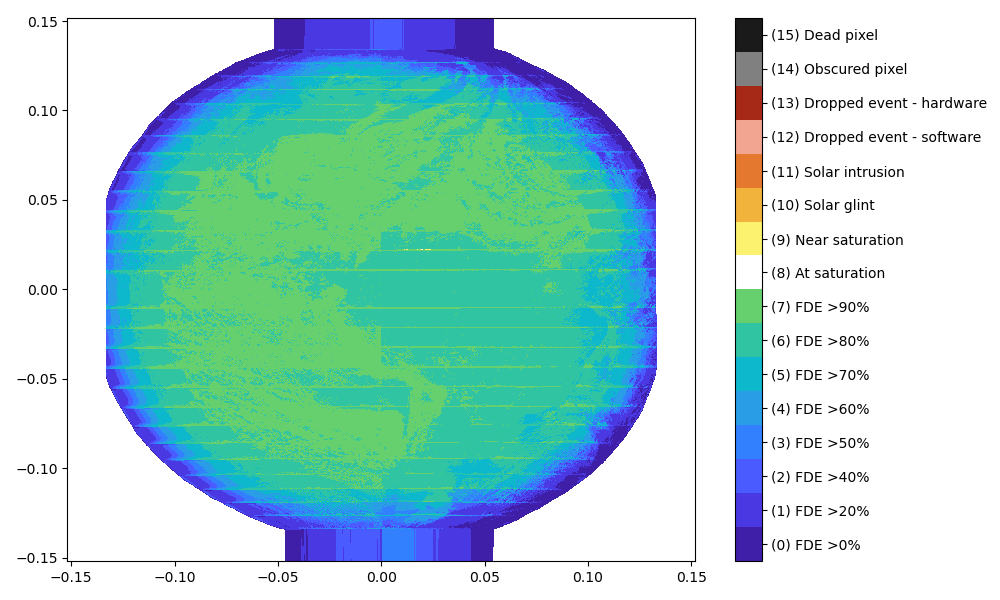

In [31]:
plt.figure(figsize=(10,6))
plt.pcolormesh(ds.x, ds.y, dqp_image_only, cmap=dqp_cmap, vmin=-0.5, vmax=15.5)
cbar = plt.colorbar(ticks=np.arange(16))
cbar.ax.set_yticklabels(dqp_labels)
plt.tight_layout()
# plt.axis(view20241011717590_saturation) # Bahama bar
# plt.axis(conus_view) # CONUS

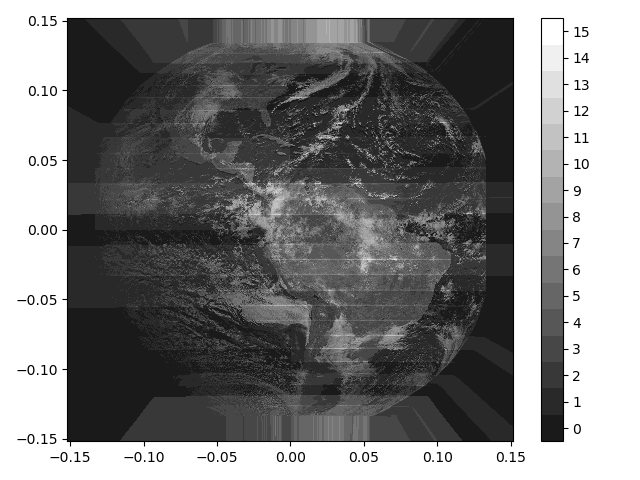

In [33]:
plt.figure()
plt.pcolormesh(ds.x, ds.y, back_image_only, cmap=back_cmap, vmin=-0.5, vmax=15.5)
cbar = plt.colorbar(ticks=np.arange(16))
plt.tight_layout()
# plt.axis(conus_view) # CONUS
# plt.axis(view20241011717590_saturation) # Bahama bar

# Create colormap files for AWIPS

In [13]:
def rgb_color_list_to_xlm_color(colorlist):
    return '\n'.join('    <color a="1.0" b="{2:4.3f}" g="{1:4.3f}" r="{0:4.3f}"/>'.format(*c) for c in colorlist)

dqp_colors_xml = rgb_color_list_to_xlm_color(dqp_colors)
back_colors_xml = rgb_color_list_to_xlm_color(back_colors)

In [14]:
colormap_template = """<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<colorMap>
{0}
</colorMap>
"""

In [15]:
dqp_xml = colormap_template.format(dqp_colors_xml)
back_xml = colormap_template.format(back_colors_xml)

In [16]:
with open("glm_dqp.cmap", "w") as f:
    f.write(dqp_xml)

with open("glm_background.cmap", "w") as f:
    f.write(back_xml)